In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
from utils.utils import show_pictures,create_folder
from estimator.estimatorUtils import Save_model,Save_images,LearningRateScheduler,lr_schedule
from estimator.estimator import WGAN_GP

In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
resume_training = True
epoch_load = "last_epoch"
batch_size = 100

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
        "data",      
        target_size=(48, 48),
        batch_size=batch_size, 
        class_mode = None,
        shuffle = True
        )

Found 63565 images belonging to 1 classes.


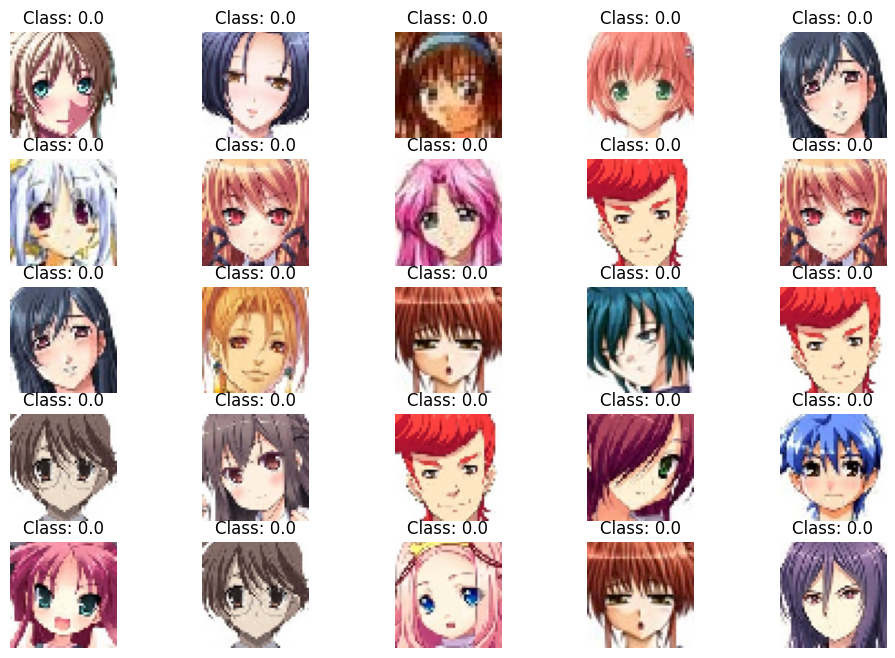

In [6]:
show_pictures(next(train_generator),np.zeros(shape= (batch_size)))

In [7]:
sm = Save_model(5,"tmp")
si = Save_images(5,"tmp",10)
lr = LearningRateScheduler(lr_schedule, lr_schedule)

In [8]:
opt1 = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
opt2 = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
model = WGAN_GP(z_dim = 15, critic_steps = 5, gp_weight = 10)

In [11]:
model.compile(critic_optimizer = opt1, generator_optimizer = opt2)

In [12]:
#logic for loading optimizer and model weights to continue training
#Need to specify the dimensions of the optimizer weights, done by applaying gradients to model trainable parameters with respect to a 0 vector
if resume_training:
    model.generator.load_weights(epoch_load + "/generator_weights.hdf5")
    model.critic.load_weights(epoch_load + "/critic_weights.hdf5")

    generator_opt_weights = np.load(epoch_load + "/generator_optimizer.npy", allow_pickle=True)
    critic_opt_weights = np.load(epoch_load + "/critic_optimizer.npy", allow_pickle=True)

    generator_grad_vars = model.generator.trainable_weights
    critic_grad_vars = model.critic.trainable_weights

    generator_zero_grads = [tf.zeros_like(w) for w in generator_grad_vars]
    critic_zero_grads = [tf.zeros_like(w) for w in critic_grad_vars]

    opt2.apply_gradients(zip(generator_zero_grads, generator_grad_vars))
    opt1.apply_gradients(zip(critic_zero_grads, critic_grad_vars))

    opt2.set_weights(generator_opt_weights)
    opt1.set_weights(critic_opt_weights)

In [13]:
#training example
history = model.fit(train_generator, epochs = 3,batch_size = batch_size, callbacks = [sm,si,lr])

Generator lr in epoch 0 is 0.00019999999494757503
Critic lr in epoch 0 is 0.00019999999494757503
Epoch 1/3
636/636 [==============================] - ETA: 0s - generator_loss: -1.8528 - critic_loss: -2.5524 - critic_real_loss: -4.9959 - critic_fake_loss: 2.1536 - gp: 0.0290Saving weights
Saving optimizer weights


C:\Users\gonzalo\AppData\Roaming\Python\Python37\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Generating vector
Generating image
1/1 [==============================] - 0s 183ms/step
Saving image
636/636 [==============================] - 719s 1s/step - generator_loss: -1.8883 - critic_loss: -2.5527 - critic_real_loss: -5.0319 - critic_fake_loss: 2.1891 - gp: 0.0290
Generator lr in epoch 1 is 0.00019999999494757503
Critic lr in epoch 1 is 0.00019999999494757503
Epoch 2/3
636/636 [==============================] - 736s 1s/step - generator_loss: -1.8394 - critic_loss: -2.4121 - critic_real_loss: -4.7072 - critic_fake_loss: 2.0060 - gp: 0.0289
Generator lr in epoch 2 is 0.00019999999494757503
Critic lr in epoch 2 is 0.00019999999494757503
Epoch 3/3
636/636 [==============================] - 813s 1s/step - generator_loss: 2.0335 - critic_loss: -2.5050 - critic_real_loss: -0.9547 - critic_fake_loss: -1.7920 - gp: 0.0242


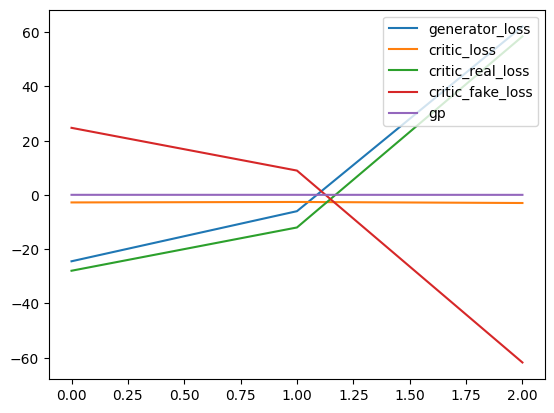

In [14]:
plt.plot(history.history["generator_loss"], label="generator_loss")
plt.plot(history.history["critic_loss"], label="critic_loss")
plt.plot(history.history["critic_real_loss"], label="critic_real_loss")
plt.plot(history.history["critic_fake_loss"], label="critic_fake_loss")
plt.plot(history.history["gp"], label="gp")
plt.legend(loc="upper right")